BiLSTM title (2+) with 2 Dense layers
Report Binary Classification (Others or not?)

In [39]:
import csv
import operator
import nltk
import string
import pandas as pd
import sklearn
from tqdm import tqdm
import logging
import numpy as np
from gensim.models import word2vec, KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize, sent_tokenize, WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
from numpy import asarray, zeros
from matplotlib import pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Embedding, Dense, Dropout, CuDNNGRU, CuDNNLSTM
from keras.layers import Input, Conv1D, GlobalMaxPooling1D, Flatten, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

from sklearn.metrics import classification_report

# Preprocessing Data

In [42]:
def read_file(filename):
    with open(filename, encoding='utf-8') as f:
        data = f.read().split('\n')
        data = data[:len(data)-1] #Clear last null row
        f.close()
    data = [row for row in csv.reader(data, quotechar='"', delimiter=',',quoting=csv.QUOTE_ALL, skipinitialspace=True)]
    data = pd.DataFrame(data[1:], columns = data[0]) #Transform to Pandas DataFrame
    return data

def tokenize_word(sentence):
    return nltk.word_tokenize(sentence)

def lowercase(words):
    return str(words).lower()

def remove_punctuation_whitespace(words): #Remove all punctuation and whitespace characters
    pun_and_ws = string.punctuation+string.whitespace
    new_words = [''.join(c for c in w if c not in pun_and_ws) for w in words]
    new_words = [w for w in new_words if w != '']
    return new_words

def remove_stopwords(words): #Remove stopwords by using nltk.corpus.stopwords
    stop_words = stopwords.words('english')
    new_words = [w for w in words if w not in stop_words]
    return new_words

def normalize(data):   
    data = [remove_punctuation_whitespace(words) for words in tqdm(data)]
    #data = [remove_stopwords(words) for words in data]
    return data

def preprocess(text):
    STOPWORDS = set(stopwords.words("english"))
    text= text.strip().lower().split(' ')
    text = filter(lambda word: word not in STOPWORDS, text)
    return " ".join(text)

if __name__ == "__main__":
    #read file
    train_data = read_file('task2_trainset.csv')
    test_data = read_file('task2_public_testset.csv')
    train_data['Abstract'] = train_data['Abstract'].apply(preprocess)
    test_data['Abstract'] = test_data['Abstract'].apply(preprocess)
    

In [43]:
#Categorical labels
train_data['EMPIRICAL'] = [1 if 'EMPIRICAL' in train_data['Task 2'][i] else 0 for i in range(len(train_data))]
train_data['ENGINEERING'] = [1 if 'ENGINEERING' in train_data['Task 2'][i] else 0 for i in range(len(train_data))]
train_data['THEORETICAL'] = [1 if 'THEORETICAL' in train_data['Task 2'][i] else 0 for i in range(len(train_data))]
train_data['OTHERS'] = [1 if 'OTHERS' in train_data['Task 2'][i] else 0 for i in range(len(train_data))]

In [45]:
#Combine train and test abtracts
abstract_total = pd.concat([train_data['Abstract'],test_data['Abstract']], ignore_index=True)

#Texts to sequences with keras
keras_tokenizer = Tokenizer()
keras_tokenizer.fit_on_texts(abstract_total)
train_abstract_encoded = keras_tokenizer.texts_to_sequences(train_data['Abstract'])
test_abstract_encoded = keras_tokenizer.texts_to_sequences(test_data['Abstract'])

#tokenize word in abstract
abstract_total_tokenized = [text_to_word_sequence(sen) for sen in abstract_total]

#pad sequences
sequence_length = max([len(sen) for sen in abstract_total_tokenized]) #max length of abstract
train_abstract_sequences = pad_sequences(train_abstract_encoded, maxlen=sequence_length)
test_abstract_sequences = pad_sequences(test_abstract_encoded, maxlen=sequence_length)

#get Word index and vocab size
word_index = keras_tokenizer.word_index
vocab_size = len(word_index) + 1









# Using gensim Word2Vec

In [48]:
#Create word vectors with gensim.models.word2vec.Word2Vec
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
model = word2vec.Word2Vec(abstract_total_tokenized, 
                 size=300, 
                 min_count=2,
                 workers=12, 
                 #sg=0, 
                 #negative=5,
                 iter=10
                )
word_vectors = model.wv

2019-10-30 20:40:28,518 : INFO : collecting all words and their counts
2019-10-30 20:40:28,519 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-30 20:40:28,680 : INFO : PROGRESS: at sentence #10000, processed 1024244 words, keeping 33301 word types
2019-10-30 20:40:28,849 : INFO : PROGRESS: at sentence #20000, processed 2019485 words, keeping 46865 word types
2019-10-30 20:40:28,964 : INFO : collected 54763 word types from a corpus of 2719697 raw words and 27000 sentences
2019-10-30 20:40:28,965 : INFO : Loading a fresh vocabulary
2019-10-30 20:40:29,023 : INFO : min_count=2 retains 33833 unique words (61% of original 54763, drops 20930)
2019-10-30 20:40:29,024 : INFO : min_count=2 leaves 2698767 word corpus (99% of original 2719697, drops 20930)
2019-10-30 20:40:29,128 : INFO : deleting the raw counts dictionary of 54763 items
2019-10-30 20:40:29,130 : INFO : sample=0.001 downsamples 31 most-common words
2019-10-30 20:40:29,131 : INFO : downsampling l

2019-10-30 20:40:41,256 : INFO : worker thread finished; awaiting finish of 11 more threads
2019-10-30 20:40:41,267 : INFO : worker thread finished; awaiting finish of 10 more threads
2019-10-30 20:40:41,271 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-10-30 20:40:41,275 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-10-30 20:40:41,286 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-10-30 20:40:41,290 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-10-30 20:40:41,296 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-10-30 20:40:41,297 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-10-30 20:40:41,299 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-30 20:40:41,306 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-30 20:40:41,311 : INFO : worker thread finished; awaiting finish of 1 more threa

In [50]:
word_vectors.most_similar('rapid')

[('upcoming', 0.6541310548782349),
 ('sustainable', 0.611328125),
 ('rapidly', 0.6015346050262451),
 ('pace', 0.6007639765739441),
 ('tremendous', 0.5923537015914917),
 ('explosive', 0.5915424227714539),
 ('proliferation', 0.5877658128738403),
 ('prototyping', 0.586971640586853),
 ('facilitating', 0.5806515216827393),
 ('technological', 0.5693603157997131)]

In [32]:
#Create embedding matrix from gensim word2vec models
embedding_matrix = zeros((vocab_size, 300))
for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
    except:
        continue
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Load GloVe embedding layer

In [20]:
embeddings_index = dict()
f = open('./glove.6B/glove.6B.300d.txt', encoding='utf-8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

400000it [00:35, 11343.99it/s]


Loaded 400000 word vectors.


In [38]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [39]:
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print('Vocab size: ', vocab_size)

Null word embeddings: 19407
Vocab size:  54764


# Deep Learning Phase

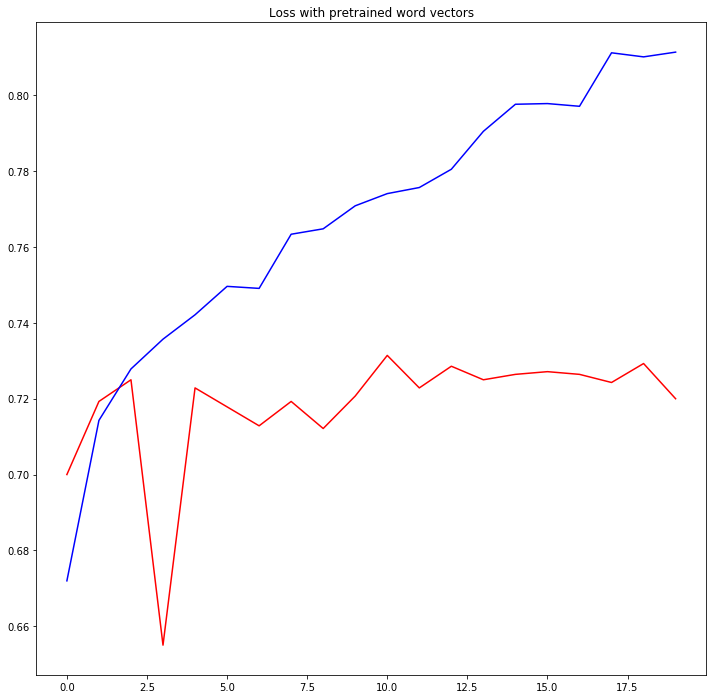

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4860
           1       0.90      0.43      0.58      2140

    accuracy                           0.81      7000
   macro avg       0.85      0.71      0.73      7000
weighted avg       0.83      0.81      0.79      7000



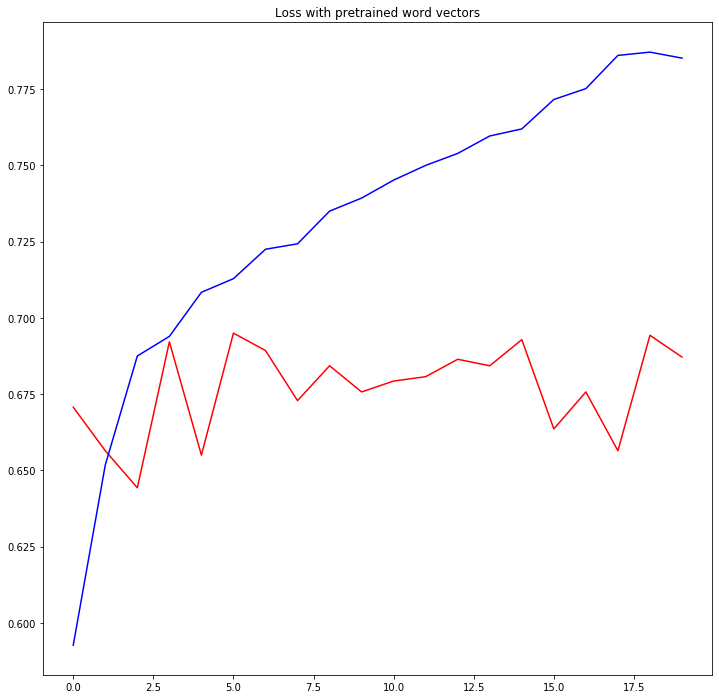

              precision    recall  f1-score   support

           0       0.71      0.95      0.81      3609
           1       0.91      0.59      0.72      3391

    accuracy                           0.78      7000
   macro avg       0.81      0.77      0.77      7000
weighted avg       0.81      0.78      0.77      7000



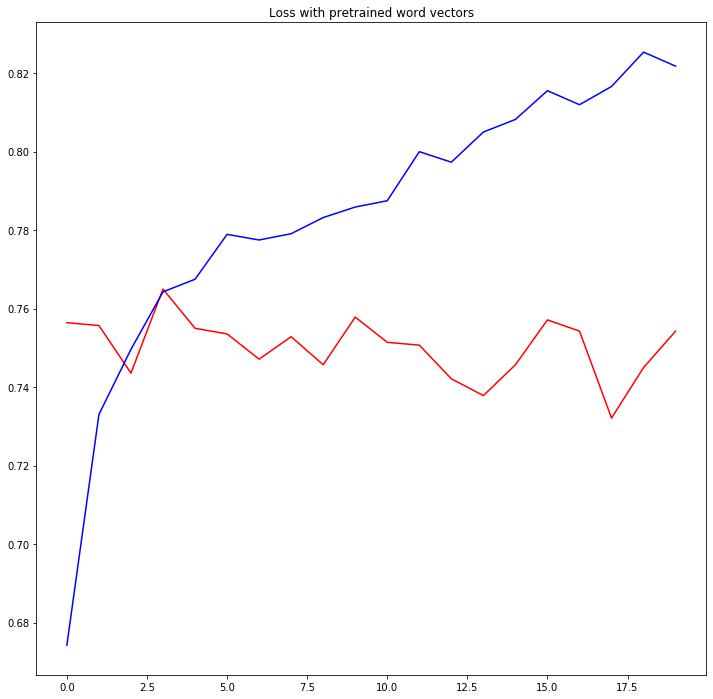

              precision    recall  f1-score   support

           0       0.72      0.99      0.84      3782
           1       0.98      0.56      0.71      3218

    accuracy                           0.79      7000
   macro avg       0.85      0.77      0.77      7000
weighted avg       0.84      0.79      0.78      7000



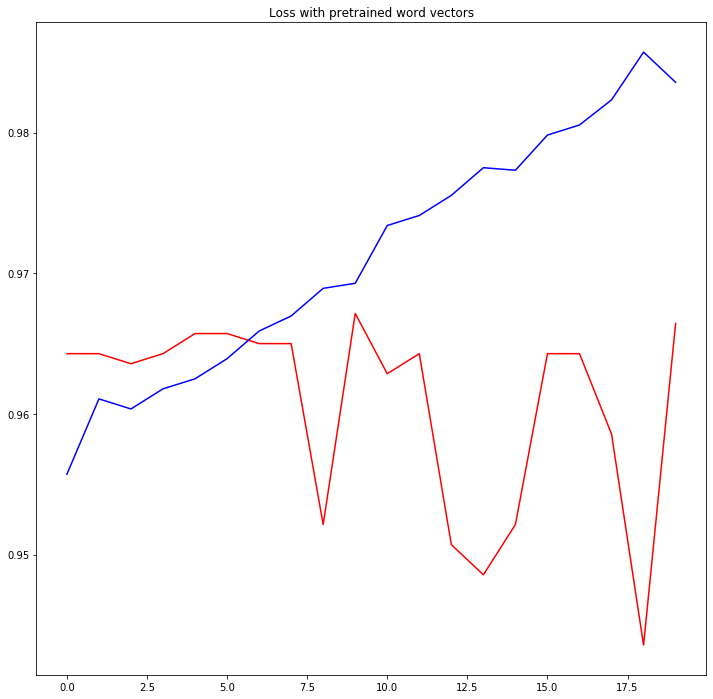

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      6741
           1       1.00      0.15      0.26       259

    accuracy                           0.97      7000
   macro avg       0.98      0.58      0.62      7000
weighted avg       0.97      0.97      0.96      7000



In [38]:
def apply_model(X_train, y_train):
    embedding_layer = Embedding(input_dim = vocab_size, 
                            output_dim = 300,
                            trainable = False,
                            weights = [embedding_matrix], 
                            input_length = sequence_length,
                            name = "Embedding"
                            )
    
    """
    #Add layers to model
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(rate=0.1))
    model.add(Conv1D(300, 1, padding='valid',activation='relu',strides=2))
    model.add(Conv1D(150, 1, padding='valid',activation='relu',strides=2))
    model.add(Conv1D(75, 1, padding='valid',activation='relu',strides=2))
    model.add(Flatten(name="Flatten"))
    model.add(Dropout(rate=0.1))
    model.add(Dense(300,activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(150,activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer = 'adam', 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])
    """
    #Model 2
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(250,1,padding='valid',activation='relu',strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.1))
    model.add(Dense(250))
    model.add(Dropout(0.1))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    #Fit model
    hist = model.fit(X_train, 
          y_train, 
          validation_split=0.2, 
          epochs=20,
          batch_size=6, 
          verbose=False,
          shuffle=True)
    
    #Plot model accuracy
    history = pd.DataFrame(hist.history)
    plt.figure(figsize=(12,12));
    plt.plot(history["val_accuracy"], 'r');
    plt.plot(history["accuracy"], 'b');
    plt.title("Loss with pretrained word vectors");
    plt.show();
    
    #Print report
    y_pred = [1 if pred>=0.8 else 0 for pred in model.predict(X_train)]
    print(classification_report(y_train, y_pred))
    
    return model, y_pred


if __name__ == "__main__":
    empirical_model, y1 = apply_model(train_abstract_sequences, train_data['EMPIRICAL'])
    engineering_model, y2 = apply_model(train_abstract_sequences, train_data['ENGINEERING'])
    theoretical_model, y3 = apply_model(train_abstract_sequences, train_data['THEORETICAL'])
    others_model, y3 = apply_model(train_abstract_sequences, train_data['OTHERS'])

In [37]:
empirical_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 511, 300)          16432500  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 511, 250)          75250     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [122]:
test_data['EMPIRICAL'] = [1 if pred>=0.5 else 0 for pred in empirical_model.predict(test_abstract_sequences)]
test_data['ENGINEERING'] = [1 if pred>=0.5 else 0 for pred in engineering_model.predict(test_abstract_sequences)]
test_data['THEORETICAL'] = [1 if pred>=0.5 else 0 for pred in theoretical_model.predict(test_abstract_sequences)]
test_data['OTHERS'] = [1 if pred>=0.5 else 0 for pred in others_model.predict(test_abstract_sequences)]

print('Number of EMPIRICAL: {}\n\
Number of ENGINEERING: {}\n\
Number of THEORETICAL: {}\n\
Number of OTHERS: {}\n'.format(sum(test_data['EMPIRICAL']), 
                                     sum(test_data['ENGINEERING']), 
                                     sum(test_data['THEORETICAL']), 
                                     sum(test_data['OTHERS'])))

Number of EMPIRICAL: 3884
Number of ENGINEERING: 10194
Number of THEORETICAL: 10077
Number of OTHERS: 302



In [128]:
test_data['EMPIRICAL'] = [1 if pred>=0.8 else 0 for pred in empirical_model.predict(test_abstract_sequences)]
test_data['ENGINEERING'] = [1 if pred>=0.8 else 0 for pred in engineering_model.predict(test_abstract_sequences)]
test_data['THEORETICAL'] = [1 if pred>=0.8 else 0 for pred in theoretical_model.predict(test_abstract_sequences)]
test_data['OTHERS'] = [1 if pred>=0.8 else 0 for pred in others_model.predict(test_abstract_sequences)]

print('First prediction: ')
print('Number of EMPIRICAL: {}\n\
Number of ENGINEERING: {}\n\
Number of THEORETICAL: {}\n\
Number of OTHERS: {}\n'.format(sum(test_data['EMPIRICAL']), 
                                     sum(test_data['ENGINEERING']), 
                                     sum(test_data['THEORETICAL']), 
                                     sum(test_data['OTHERS'])))

for i in tqdm(range(len(test_data))):
    if test_data['OTHERS'][i]==1:
        test_data.loc[i, 'EMPIRICAL'] = 0
        test_data.loc[i, 'ENGINEERING'] = 0
        test_data.loc[i, 'THEORETICAL'] = 0
        
print('\nAfter modifiying: ')
print('Number of EMPIRICAL: {}\n\
Number of ENGINEERING: {}\n\
Number of THEORETICAL: {}\n\
Number of OTHERS: {}\n'.format(sum(test_data['EMPIRICAL']), 
                                     sum(test_data['ENGINEERING']), 
                                     sum(test_data['THEORETICAL']), 
                                     sum(test_data['OTHERS'])))

First prediction: 
Number of EMPIRICAL: 2698
Number of ENGINEERING: 8400
Number of THEORETICAL: 8371
Number of OTHERS: 133



100%|█████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 28402.71it/s]



After modifiying: 
Number of EMPIRICAL: 2680
Number of ENGINEERING: 8356
Number of THEORETICAL: 8336
Number of OTHERS: 133



In [135]:
submission = test_data[['Id','THEORETICAL','ENGINEERING','EMPIRICAL','OTHERS']]
submission

,Id,THEORETICAL,ENGINEERING,EMPIRICAL,OTHERS
0,T00001,0,1,1,0
1,T00002,0,1,0,0
2,T00003,0,0,0,0
3,T00004,1,0,0,0
4,T00005,0,0,0,0
...,...,...,...,...,...
19995,T19996,0,1,0,0
19996,T19997,1,1,0,0
19997,T19998,1,0,0,0
19998,T19999,0,1,0,0


In [136]:
submission.to_csv(r'submission.csv', index=False, header=True, encoding='utf-8')